## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype import DataGrabber, Workflow, Node

In [2]:
os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/'))

'/home/matay/Documents/MATLAB/spm12'

In [3]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [4]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [5]:
# spm.SPMCommand().version

In [6]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [7]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [8]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']
# below info referred by datagrabber needs to be referred within infosource, selectfiles 
#info = dict(
#    func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
#    struct=[['Structural', 'subject_id', 7, '']])

# TR of functional images
TR = 2.
# Smoothing width used during preprocessing
fwhm = [8]

In [9]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [10]:
anat_file = os.path.join('Structural', 'sM03953_0007.img')
func_file = os.path.join('RawEPI', 'sM03953_0005_*.img')

templates = {'struct':anat_file,
            'func':func_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

In [11]:
merge = Node(interface=fsl.Merge(), name="merge")
merge.inputs.dimension = "t" 
merge.inputs.output_type = 'NIFTI'

In [12]:
realigner = Node(interface=Realign(), name='realign')
# realigner.inputs.in_files = func_file
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [13]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
# st.inputs.in_files = anat_file
slicetiming.inputs.num_slices = 24
slicetiming.inputs.time_repetition = 2.
slicetiming.inputs.time_acquisition = 1.92
slicetiming.inputs.slice_order = list(range(24,0,-1))
slicetiming.inputs.ref_slice = 12
slicetiming.inputs.out_prefix = 'a'

In [14]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]

In [15]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [16]:
segment =  Node(NewSegment(), name="newsegment")
# seg.inputs.channel_files = '/data/preproc/coregister/sub-01_T1w.nii'
#seg.inputs.channel_files = '/data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [17]:
normalize = Node(Normalize12(), name="normalize") 
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [18]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [19]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False]
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='svg'

In [20]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [21]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [22]:
preproc = Workflow(name='event_preproc_art')
preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [23]:
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, merge, [('func', 'in_files')]),
                 (merge, datasink, [('merged_file', 'preproc.@merged_file')]),
                 (merge, realigner, [('merged_file', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'source'), 
                                          ('realigned_files', 'apply_to_files')]),
                 (realigner, datasink, [('realignment_parameters', 'preproc.@realignement_parameters')]),
                 (selectfiles, coregister, [('struct', 'target')]), 
                 (coregister, datasink, [('coregistered_source', 'preproc.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'preproc.@bias_corrected_images'), 
                                 ('transformation_mat', 'preproc.@transformation_mat'),
                                 ('native_class_images', 'preproc.@native_class_images'),
                                 ('forward_deformation_field', 'preproc.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smoothed_files')]),
                 (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 (normalize, art, [('normalized_files', 'realigned_files')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
])

In [24]:
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240517-17:19:25,165 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png'

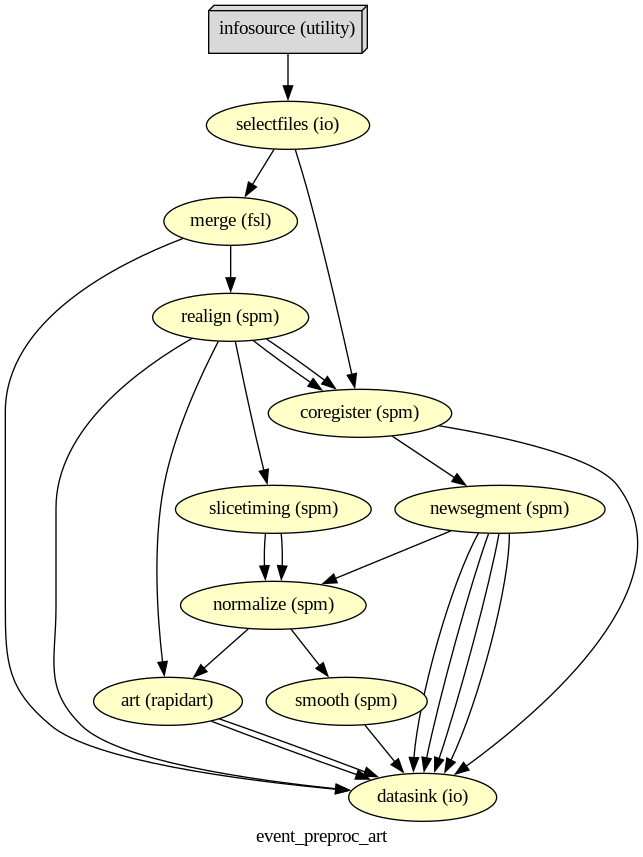

In [25]:
# Visualize the graph
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png', width=750)

In [26]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_graph.dot')

240517-17:19:45,667 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_art/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_art/flat_graph.png'

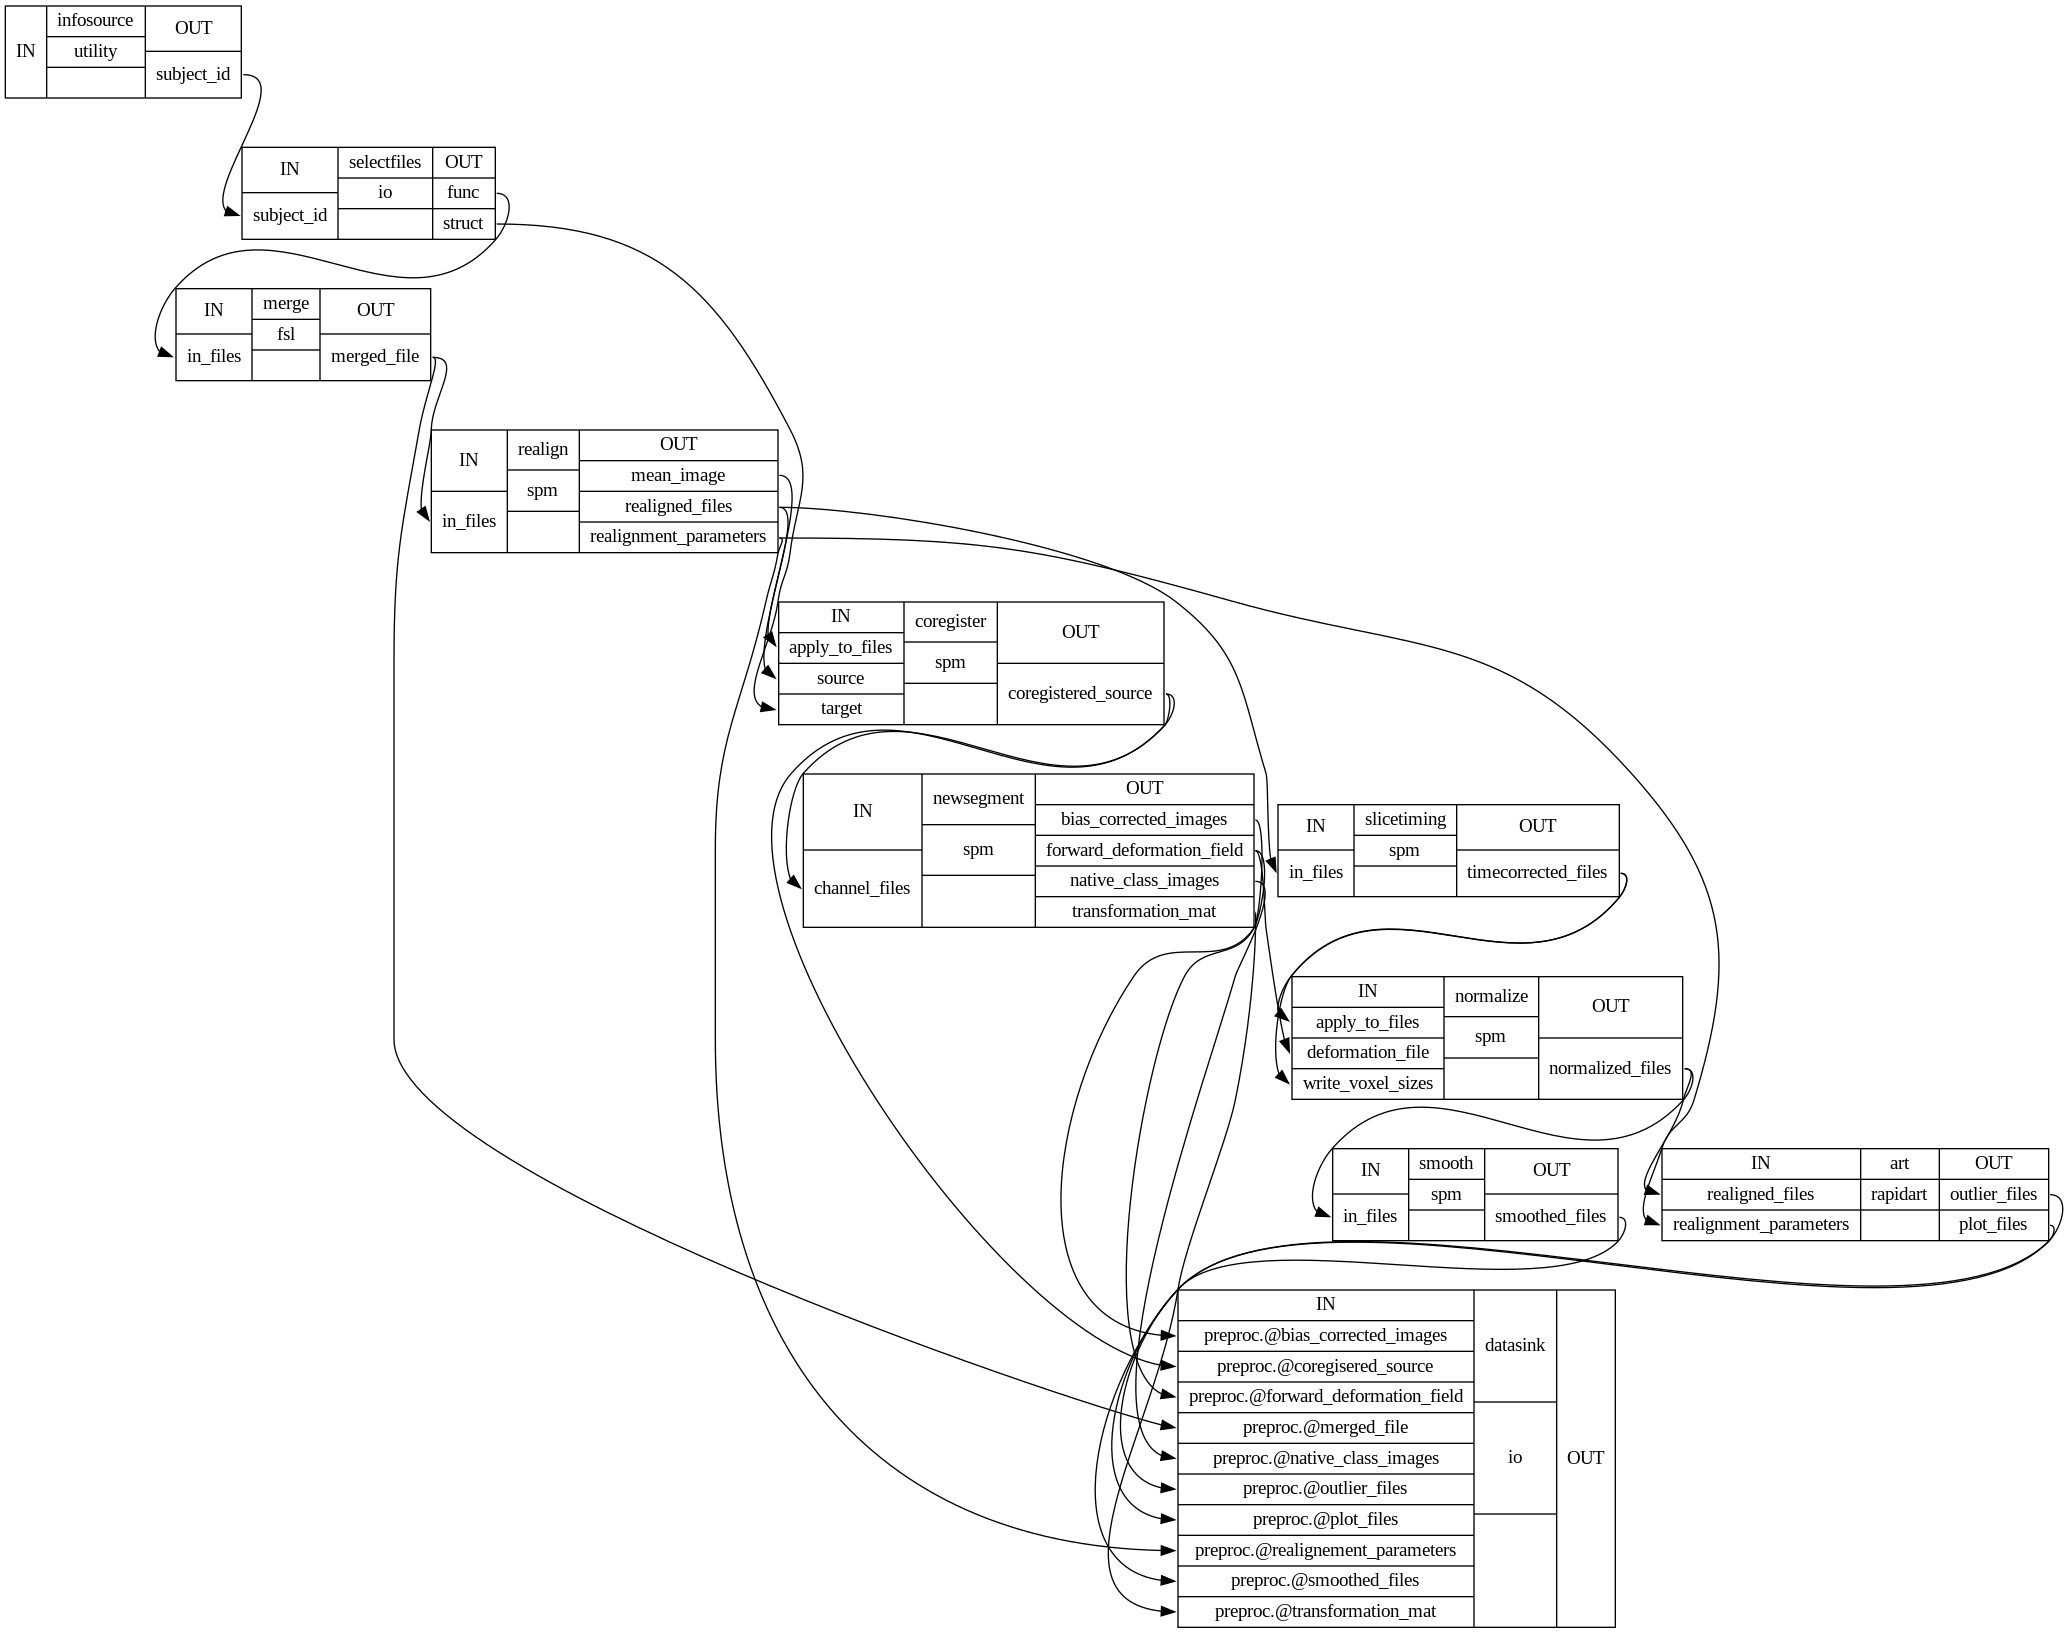

In [27]:
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/event_preproc_art/flat_graph_detailed.png' )

In [28]:
preproc.run()

240517-17:20:19,805 nipype.workflow INFO:
	 Workflow event_preproc_art settings: ['check', 'execution', 'logging', 'monitoring']
240517-17:20:19,812 nipype.workflow INFO:
	 Running serially.
240517-17:20:19,812 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/selectfiles".
240517-17:20:19,813 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240517-17:20:19,815 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001675s.
240517-17:20:19,822 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.merge" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/merge".
240517-17:20:19,834 nipype.workflow INFO:
	 [Node] Executing "merge" <nipype.interfaces.fsl.utils.Merge>
240517-17:20:20,427 nipype.workflow INFO:
	 [Node] Finished "merge", elapsed time 0.591794s.
240517-17:20:20,430 nipype

stty: 'standard input': Inappropriate ioctl for device


240517-17:21:14,143 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 45.986343s.
240517-17:21:14,149 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/slicetiming".
240517-17:21:14,151 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240517-17:21:29,798 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 15.646375s.
240517-17:21:29,800 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.coregister" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/coregister".
240517-17:21:29,824 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240517-17:21:58,383 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 28.558157s.
240517-17:21:58,391 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.newsegment" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/newsegment".
240517-17:21:58,394 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240517-17:22:21,697 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 23.303133s.
240517-17:22:21,700 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.normalize" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/normalize".
240517-17:22:21,723 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240517-17:22:42,800 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 21.076616s.
240517-17:22:42,810 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.smooth" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/smooth".
240517-17:22:42,812 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240517-17:23:00,167 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 17.355181s.
240517-17:23:00,170 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.art" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/art".
240517-17:23:00,173 nipype.workflow INFO:
	 [Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>


stty: 'standard input': Inappropriate ioctl for device


240517-17:23:00,533 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 0.35929s.
240517-17:23:00,535 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.datasink" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/datasink".
240517-17:23:00,540 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240517-17:23:00,963 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.422167s.
